<a href="https://colab.research.google.com/github/DimitriLeandro/DA2Group10/blob/main/pretrained_satellighte_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading datasets and importing libs

In [ ]:
!pip install satellighte

In [ ]:
import imageio
import satellighte as sat
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchmetrics as tm
import pytorch_lightning as pl
from pathlib import Path
from PIL import Image
from torch import flatten
from torchvision import transforms as tt
from torchvision.transforms.transforms import Resize
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# !wget -q https://uni-muenster.sciebo.de/s/KNjoOrXdWecbvdh/download?path=%2F&files=training_patches.zip
# !unzip -qq /content/download?path=%2F
# !unzip -qq /content/task_2/training_patches.zip
# !unzip -qq /content/task_2/unlabeled_training_data.zip
# !unzip -qq /content/task_2/validation_data.zip

## Mounting drive to save model checkpoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Loading pretrained model

In [ ]:
sat.available_models()

['efficientnet_b0_eurosat', 'mobilenetv2_default_eurosat']

In [ ]:
# del model, train_tt, val_tt, hparams, train_ds, val_ds, train_dl, val_dl, trainer, checkpoint_callback

In [ ]:
model_name = 'mobilenetv2_default_eurosat'
model = sat.Classifier.from_pretrained(
    model_name, 
    sat.get_model_latest_version(model_name)
)

Downloading: "https://github.com/canturan10/satellighte/releases/download/v0.0.11/mobilenetv2_default_eurosat.pth" to /usr/local/lib/python3.7/dist-packages/satellighte/models/mobilenetv2_default_eurosat/v1/mobilenetv2_default_eurosat.pth
100%|██████████| 8.77M/8.77M [00:00<00:00, 13.5MB/s]


In [ ]:
img_urls = [
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/AnnualCrop.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/Forest.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/HerbaceousVegetation.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/PermanentCrop.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/River.jpg'
]

model.eval()

for img_url in img_urls:
    img = imageio.imread(img_url)
    results = model.predict(img)
    plt.imshow(img)
    plt.show()
    print(img_url.split('/')[-1])
    print(results, '\n\n')

## Image transformers

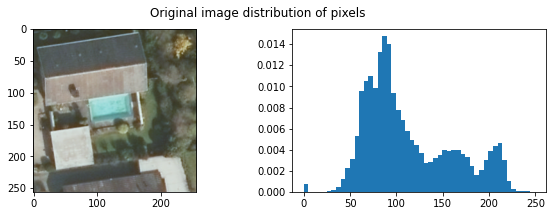

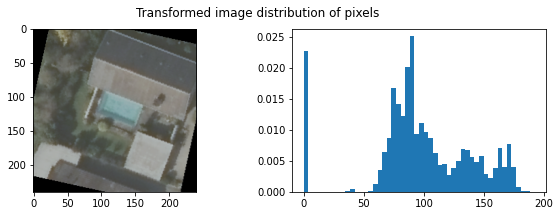

In [ ]:
# this method sets model.mean and model.std
model.configure_preprocess()

# input size of images
input_size = (240, 240)

# creating a preprocessing + data augmentation unit for the training data
train_tt = tt.Compose([
    tt.Resize(input_size),
    tt.ColorJitter(brightness=0.15, contrast=0.33, saturation=0.2, hue=0.05),
    tt.RandomRotation(degrees=15),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomVerticalFlip(p=0.5),
    # tt.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 0.1)),
    # tt.RandomPerspective(distortion_scale=0.1, p=0.2),
    # tt.RandomPosterize(bits=2),
])

# creating a preprocessing unit for the validation data
val_tt = tt.Compose([
  tt.Resize(input_size)
])

# loading an image sample
# '../../../mnt/c/Users/dimit/Downloads/training_patches/training_patches/background/1G52LP.png'
img = Image.open('/content/drive/MyDrive/training_patches/pools/4B37MU.png')

# lets have a look at the original image and its pixels values distribution
plt.rcParams['figure.figsize'] = (10,3)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[1].hist(np.asarray(img).ravel(), bins=50, density=True)
plt.suptitle('Original image distribution of pixels')
plt.show()

# using the preprocessing operations to transform the image to a pytorch tensor
img_tt = train_tt(img)
 
# lets have a look at the trasnformed image and its pixels values distribution
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tt)
axs[1].hist(np.asarray(img_tt).ravel(), bins=50, density=True)
plt.suptitle('Transformed image distribution of pixels')
plt.show()

## Hyperparameters

In [ ]:
hparams = {
    'learning_rate': 1e-5,
    'momentum':      0.9,
    'weight_decay':  5e-4,
    'gamma':         0.5,
    'milestones':    [1, 5, 10, 20, 50, 100],
    'max_epoch':     20,
    'batch_size':    32,
    'criterion':     'cross_entropy',
    'optimizer':     'sgd',
    'device':        torch.cuda.current_device() #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
}

## Loading dataset

We need to create our own Dataset class that inherit torch.Dataset in order to create a torch.utils.data.DataLoader and fine tune the model. 

To do this, modify this code: https://github.com/canturan10/satellighte/blob/master/satellighte/datasets/eurosat.py

In [ ]:
class CustomDataset(sat.datasets.base.BaseDataset):
    
    def __init__(
        self, 
        root_dir, 
        transforms, 
        max_background_imgs = 500,
        max_pools_imgs      = 500,
        max_pounds_imgs     = 500,
        max_solar_imgs      = 500,
        max_trampoline_imgs = 500
    ):
        self.root_dir            = root_dir
        self.transforms          = transforms
        self.max_background_imgs = max_background_imgs
        self.max_pools_imgs      = max_pools_imgs
        self.max_pounds_imgs     = max_pounds_imgs
        self.max_solar_imgs      = max_solar_imgs
        self.max_trampoline_imgs = max_trampoline_imgs
        ids, targets    = self._get_dataset()
        super().__init__(ids, targets, transforms=transforms)

    @property
    def num_classes(self):
        return len(self.__classes)

    @property
    def classes(self):
        return self.__classes

    def name_to_id(self, name: str):
        return self.__classes.index(name)

    def id_to_name(self, idx):
        return self.__classes[idx]

    def _get_dataset(self):
        labels          = []
        filenames       = []
        background_imgs_count = self.max_background_imgs
        pools_imgs_count      = self.max_pools_imgs
        pounds_imgs_count     = self.max_pounds_imgs
        solar_imgs_count      = self.max_solar_imgs
        trampoline_imgs_count = self.max_trampoline_imgs
        
        for class_path in self.root_dir.iterdir():
            if class_path.is_file():
                continue
            for img_path in class_path.iterdir():
                if img_path.suffix != '.png':
                    continue
                filenames.append(img_path)
                labels.append(class_path.name)

                if class_path.name == 'background':
                    background_imgs_count -= 1
                    if background_imgs_count == 0:
                        break
                if class_path.name == 'pools':
                    pools_imgs_count -= 1
                    if pools_imgs_count == 0:
                        break
                if class_path.name == 'pounds':
                    pounds_imgs_count -= 1
                    if pounds_imgs_count == 0:
                        break
                if class_path.name == 'solar':
                    solar_imgs_count -= 1
                    if solar_imgs_count == 0:
                        break
                if class_path.name == 'trampoline':
                    trampoline_imgs_count -= 1
                    if trampoline_imgs_count == 0:
                        break
                
        filenames = np.asarray(filenames)
        labels = np.asarray(labels)

        labels = labels[filenames.argsort()]
        filenames = filenames[filenames.argsort()]

        # convert to integer labels
        label_encoder = LabelEncoder()
        label_encoder.fit(np.sort(np.unique(labels)))
        labels = label_encoder.transform(labels)
        labels = np.asarray(labels)

        # remember label encoding
        self.__classes = list(label_encoder.classes_)
            
        return filenames.tolist(), labels.tolist()

In [ ]:
# train dataset
train_ds = CustomDataset(
    # '../../../mnt/c/Users/dimit/Downloads/training_patches/training_patches/'
    root_dir            = Path('/content/drive/MyDrive/training_patches'),
    transforms          = train_tt,
    max_background_imgs = 3000,
    # max_pools_imgs      = 50,
    # max_pounds_imgs     = 50,
    # max_solar_imgs      = 50,
    # max_trampoline_imgs = 50
)

# val dataset
val_ds = CustomDataset(
    # '../../../mnt/c/Users/dimit/Downloads/unlabeled_training_data/validation_labeled_data_0FRGJD/'
    root_dir   = Path('/content/drive/MyDrive/validation_labeled_data'),
    transforms = train_tt,
    # max_background_imgs = 10,
    # max_pools_imgs      = 10,
    # max_pounds_imgs     = 10,
    # max_solar_imgs      = 10,
    # max_trampoline_imgs = 10
)

# creating DataLoader for training
train_dl = DataLoader(
    train_ds,
    batch_size = hparams.get('batch_size'),
    shuffle    = True,
)

# creating DataLoader for valdiation
val_dl = DataLoader(
    val_ds,
    batch_size = hparams.get('batch_size'),
    shuffle    = False,
)

In [ ]:
print('classes and n of samples in training data:', np.unique(train_ds.targets, return_counts=True))
print('classes and n of samples in validation data:', np.unique(val_ds.targets, return_counts=True))

classes and n of samples in training data: (array([0, 1, 2, 3, 4]), array([3000,   16,   30,  137,  355]))
classes and n of samples in validation data: (array([0, 1, 2, 3, 4]), array([91,  8,  9, 33, 85]))


## Setting training environment

In [ ]:
# adding the metric we'd like to measure while the epochs go on
model.add_metric(
    'balanced_accuracy',
    tm.Accuracy(
        num_classes = len(train_ds.classes),
        average     = 'weighted'
    )
)

# model.add_metric(
#     'average_precision',
#     tm.AveragePrecision(
#         num_classes = len(train_ds.classes),
#         average     = 'weighted'
#     ),
# )

In [ ]:
 # define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath    = '/content/drive/MyDrive/task_2_models_checkpoint', # path to save the model
    filename   = 'task_2_model_checkpoint_dense_layers',            # filename to save the model
    monitor    = 'metrics/balanced_accuracy',                       # metric to monitor
    mode       = 'max',                                             # save max metric value
    save_top_k = 3,                                                 # number of models to keep
    verbose    = True,                                              # print information about the model checkpointing
)

In [ ]:
# define trainer
trainer = pl.Trainer(
    default_root_dir        = '/content/drive/MyDrive/lightning_logs', # Default path for logs and weights
    accelerator             = 'gpu',                     # gonna need GPU
    gpus                    = hparams.get('device'),     # GPU device
    max_epochs              = hparams.get('max_epoch'),  # stop training once this number of epochs is reached
    accumulate_grad_batches = 4,                         # accumulates grads every k batches 
    check_val_every_n_epoch = 1,                         # check validation every n train epochs.
    deterministic           = True,                      # set to True to disable randomness in the model
    callbacks               = [                          # callback for checkpointing
        checkpoint_callback,
        pl.callbacks.RichProgressBar(),
    ],  
)

## Modifying top layers to fit 5 classes instead of 10

In [ ]:
model.model.backbone.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=1280, out_features=50, bias=True),
    torch.nn.LeakyReLU(negative_slope=0.05),
    torch.nn.Linear(in_features=50, out_features=5, bias=True)
)

In [ ]:
# need this command to turn on dropout layers during training
model.train()

# freezing parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# unfreezing dense layers
for parameter in model.model.backbone.classifier.parameters():
    parameter.requires_grad = True

In [ ]:
model.model.backbone.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=1280, out_features=50, bias=True)
  (2): LeakyReLU(negative_slope=0.05)
  (3): Linear(in_features=50, out_features=5, bias=True)
)

## Fitting top layers

In [ ]:
# fit the model
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=[train_dl]) #val_dl])

## Fine tuning all parameters

In [ ]:
del trainer, checkpoint_callback

In [ ]:
# define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath    = '/content/drive/MyDrive/task_2_models_checkpoint', # path to save the model
    filename   = 'task_2_model_checkpoint_all_layers_round_5',      # filename to save the model
    monitor    = 'metrics/balanced_accuracy',                       # metric to monitor
    mode       = 'max',                                             # save max metric value
    save_top_k = 3,                                                 # number of models to keep
    verbose    = True,                                              # print information about the model checkpointing
)

# define trainer
trainer = pl.Trainer(
    default_root_dir        = '/content/drive/MyDrive/', # Default path for logs and weights
    accelerator             = 'gpu',                     # gonna need GPU
    gpus                    = hparams.get('device'),     # GPU device
    max_epochs              = hparams.get('max_epoch'),  # stop training once this number of epochs is reached
    accumulate_grad_batches = 4,                         # accumulates grads every k batches 
    check_val_every_n_epoch = 1,                         # check validation every n train epochs.
    deterministic           = True,                      # set to True to disable randomness in the model
    callbacks               = [                          # callback for checkpointing
        checkpoint_callback,
        pl.callbacks.RichProgressBar(),
    ],  
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Loading last checkpoint

In [ ]:
last_ckpt = torch.load('/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_all_layers_round_4-v1.ckpt')
model.load_state_dict(last_ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
model.train()

for parameter in model.parameters():
    parameter.requires_grad = True

# model.zero_grad()

In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=[val_dl])

Epoch 18  ━━━━━━━╸━━━━━━━━━━━━━━━━ 39/119 0:00:40 • 0:01:24 0.96it/s loss: 0.0909 v_num: 5   
                                                                     metrics/balanced_accura…
                                                                     0.677                   